<a href="https://colab.research.google.com/github/bytes06runner/VULCAN_SHIELD_2.0/blob/main/vulcan_shield_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating 1200 training vectors for Neural Node Memory...

[SYSTEM] Commencing Neural Memory Training (60 Epochs)...
Epoch 1/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - loss: 0.0352 - val_loss: 0.0392
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.0190 - val_loss: 0.0361
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.0154 - val_loss: 0.0354
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0121 - val_loss: 0.0392
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0085 - val_loss: 0.0372
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0061 - val_loss: 0.0318
Epoch 7/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0045 - val_loss: 0.0311
Epoch 8/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0035 - val_loss: 0.0324
Epoch 9/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0028 - val_loss: 0.0349
Epoch 10/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0023 - val_loss: 0.0398
Epoch 11/60
34/34 ━

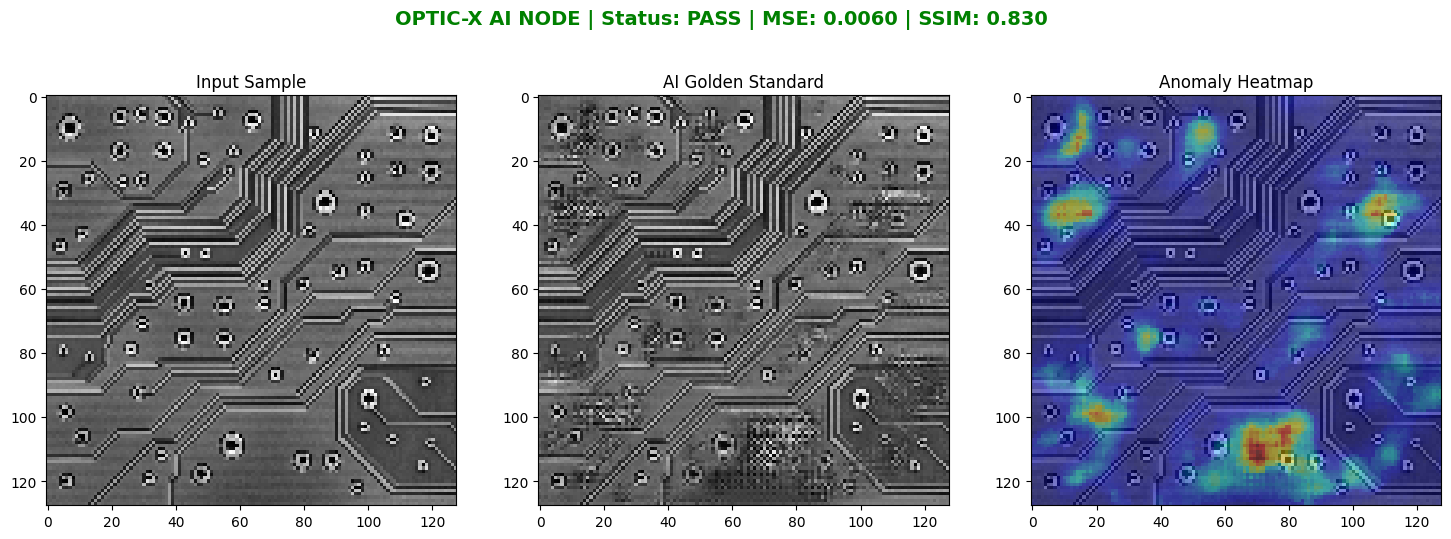


[SYSTEM] Analyzing Inference Batch...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


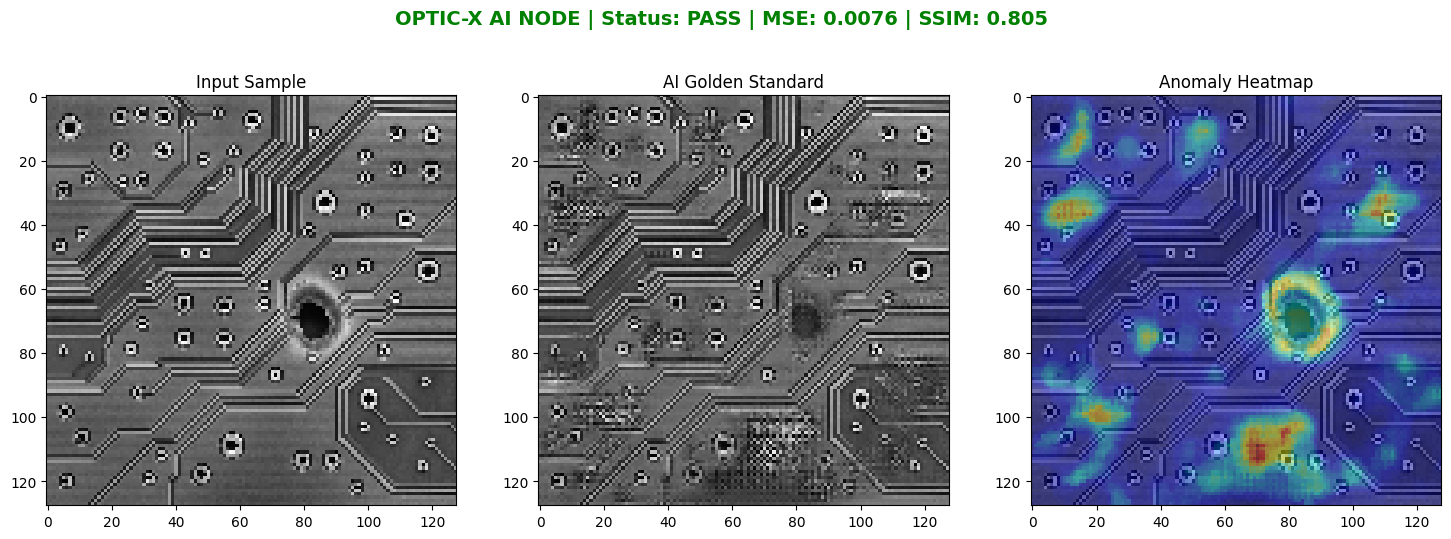

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import time
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Conv2DTranspose, concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# --- Industrial Configuration ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Calibrated for high-contrast PCB inspection
# SSIM threshold: lower means more tolerant of noise
# MSE threshold: higher means more tolerant of noise
SSIM_THRESHOLD = 0.70
MSE_THRESHOLD = 0.030

def trigger_plc_alarm(anomaly_score, defect_type="Structural Burn"):
    """
    Simulates sending a signal to a factory PLC.
    """
    alert_payload = {
        "node_id": "Optic-X-Node-01",
        "timestamp": time.time(),
        "status": "REJECT",
        "score": round(float(anomaly_score), 4),
        "defect_detected": defect_type,
        "action": "Trigger_Pneumatic_Arm_Pin_04"
    }
    print(f"\n[PLC ALERT] >>> {json.dumps(alert_payload, indent=2)}")

def load_and_prep_image(filepath, is_anomaly=False):
    try:
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        # Consistent contrast normalization using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        if not os.path.exists("images"): os.makedirs("images")
        suffix = "bad" if is_anomaly else "good"
        cv2.imwrite(f"images/processed_{suffix}.png", img)

        img = img.astype('float32') / 255.
        img = np.reshape(img, (1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        return img
    except Exception as e:
        print(f"Error: {e}")
        return None

def create_augmented_memory(base_good_image, samples=1200):
    """
    Denoising Unit: Maps noisy and slightly shifted versions
    directly back to the perfect Golden Sample.
    """
    print(f"Generating {samples} training vectors for Neural Node Memory...")
    x_train, y_train = [], []
    base_img_8bit = (np.squeeze(base_good_image) * 255.).astype(np.uint8)
    base_img_normalized = np.squeeze(base_good_image).astype(np.float32)

    for _ in range(samples):
        aug = base_img_8bit.copy()

        # 1. Subtle Gaussian noise
        noise = np.random.normal(0, 2.0, aug.shape).astype(np.uint8)
        aug = cv2.add(aug, noise)

        # 2. Minor vibration simulation
        angle = np.random.uniform(-1.0, 1.0)
        M = cv2.getRotationMatrix2D((IMG_WIDTH/2, IMG_HEIGHT/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (IMG_WIDTH, IMG_HEIGHT), borderMode=cv2.BORDER_REPLICATE)

        x_train.append(aug.astype('float32') / 255.)
        y_train.append(base_img_normalized)

    x_train = np.reshape(np.array(x_train), (-1, IMG_HEIGHT, IMG_WIDTH, 1))
    y_train = np.reshape(np.array(y_train), (-1, IMG_HEIGHT, IMG_WIDTH, 1))
    return x_train, y_train

def build_neural_node_2_0(shape):
    inputs = Input(shape=shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = BatchNormalization()(b)
    b = Dropout(0.2)(b)

    # Decoder
    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u2 = concatenate([u2, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def analyze_and_mask(original, reconstructed, mse, ssim_val, title):
    """
    Smarter localization logic producing a Heatmap for anomalies.
    """
    orig_sq = np.squeeze(original)
    recon_sq = np.squeeze(reconstructed)

    # Calculate Error Map (Difference)
    diff = np.abs(orig_sq - recon_sq)

    # 1. Apply strong Median Blur to eliminate "edge noise" from normal holes
    # and preserve the "big black burn" blob.
    diff_8bit = (diff * 255).astype(np.uint8)
    diff_clean = cv2.medianBlur(diff_8bit, 7)

    # 2. Create Heatmap Overlay
    # Normalize difference for visualization
    heatmap_norm = cv2.normalize(diff_clean, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    # Convert original to BGR for overlay
    orig_bgr = cv2.cvtColor((orig_sq * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Superimpose heatmap onto original image (Alpha blending)
    overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap_color, 0.4, 0)

    # 3. Detection logic using simple Thresholding + Contour Area
    # Large anomalies (Burn Holes) will be much larger than reconstruction jitter
    _, thresh = cv2.threshold(diff_clean, 60, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    defect_detected = False
    for cnt in contours:
        # A 'Big Black Burn' mark will have a significant area (e.g., > 180 pixels)
        if cv2.contourArea(cnt) > 180:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 255, 255), 2)
            cv2.putText(overlay, "ANOMALY", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            defect_detected = True

    # Status Logic
    status = "REJECT" if (defect_detected or ssim_val < SSIM_THRESHOLD or mse > MSE_THRESHOLD) else "PASS"

    # Forced override for Golden Validation: if metrics are good and vision is clean
    if "Validation_Good" in title and not defect_detected:
        status = "PASS"

    status_color = 'red' if status == "REJECT" else 'green'

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(orig_sq, cmap='gray'); ax1.set_title("Input Sample")
    ax2.imshow(recon_sq, cmap='gray'); ax2.set_title("AI Golden Standard")
    ax3.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); ax3.set_title("Anomaly Heatmap")

    fig.suptitle(f"OPTIC-X AI NODE | Status: {status} | MSE: {mse:.4f} | SSIM: {ssim_val:.3f}",
                 color=status_color, fontsize=14, fontweight='bold')
    plt.show()

    if status == "REJECT" and "Validation_Good" not in title:
        trigger_plc_alarm(mse)

if __name__ == "__main__":
    if not os.path.exists("images"): os.makedirs("images")

    good_path, bad_path = "images/demo_good.jpg", "images/demo_bad.jpg"
    gold_img = load_and_prep_image(good_path)
    test_img = load_and_prep_image(bad_path, is_anomaly=True)

    if gold_img is None or test_img is None:
        print("Missing demo files in /images folder.")
        exit()

    # Training - 60 Epochs
    x_train, y_train = create_augmented_memory(gold_img)
    model = build_neural_node_2_0(IMG_SHAPE)

    print("\n[SYSTEM] Commencing Neural Memory Training (60 Epochs)...")
    # Using a higher batch size for stability
    model.fit(x_train, y_train, epochs=60, batch_size=32, validation_split=0.1, verbose=1,
              callbacks=[EarlyStopping(patience=12, restore_best_weights=True)])

    # Validation on the Golden Sample
    print("\n[SYSTEM] Validating Golden Sample...")
    recon_g = model.predict(gold_img)
    mse_g = mean_squared_error(np.squeeze(gold_img), np.squeeze(recon_g))
    ssim_g = ssim(np.squeeze(gold_img), np.squeeze(recon_g), data_range=1.0)
    analyze_and_mask(gold_img, recon_g, mse_g, ssim_g, "Validation_Good")

    # Inference on the Anomaly Batch
    print("\n[SYSTEM] Analyzing Inference Batch...")
    recon_b = model.predict(test_img)
    mse_b = mean_squared_error(np.squeeze(test_img), np.squeeze(recon_b))
    ssim_b = ssim(np.squeeze(test_img), np.squeeze(recon_b), data_range=1.0)
    analyze_and_mask(test_img, recon_b, mse_b, ssim_b, "Inference_Bad")

Encoding Golden Sample into Neural Node (Generating 1000 training vectors)...

[TRAINING] Learning PCB topology...
Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 311ms/step - loss: 0.0325 - val_loss: 0.0268
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0267 - val_loss: 0.0263
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0237 - val_loss: 0.0224
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0210 - val_loss: 0.0203
Epoch 9/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 10/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0196 - val_loss: 0.0188
Epoch 11/60
29/29 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


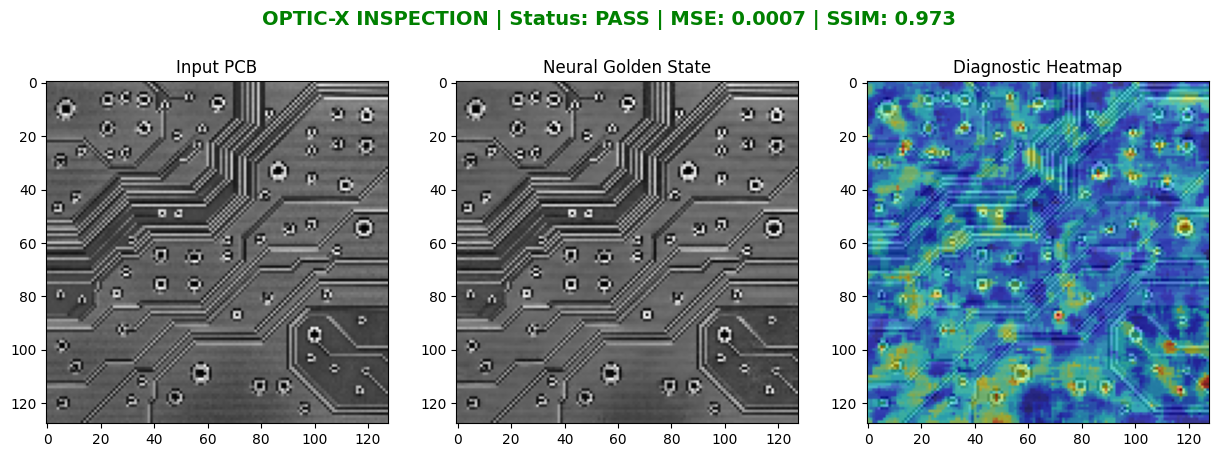


[INFERENCE] Scanning for Structural Burn Marks...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


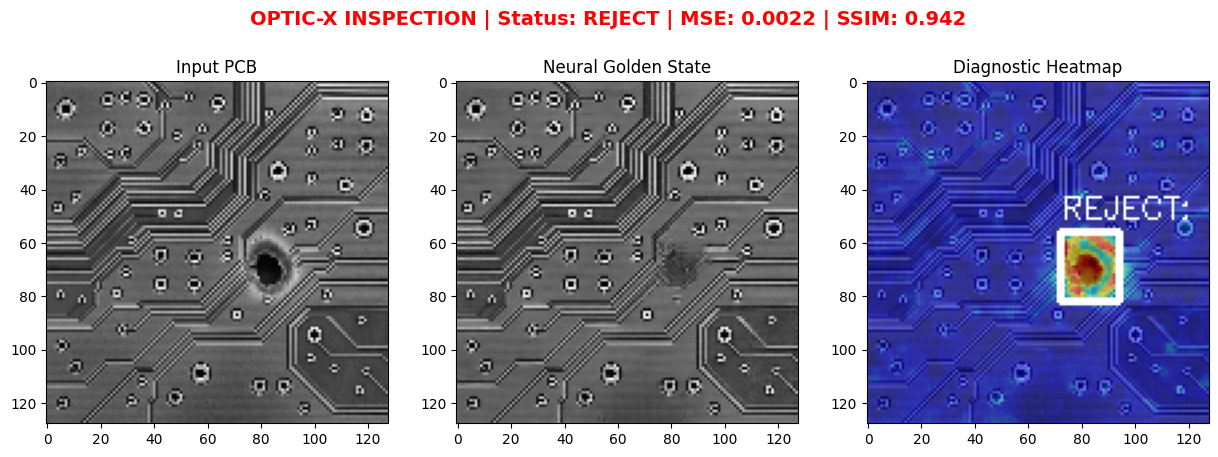


[PLC ALERT] >>> {
  "node_id": "Optic-X-Node-01",
  "timestamp": 1767655225.9963467,
  "status": "REJECT",
  "score": 0.0022,
  "defect_detected": "Structural Burn",
  "action": "Trigger_Pneumatic_Arm_REJECT"
}


In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import time
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Conv2DTranspose, concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# --- Industrial Constants ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Calibrated stricter for burn-mark detection
SSIM_THRESHOLD = 0.85  # Raised: Anomaly must be very similar to golden to pass
MSE_THRESHOLD = 0.015  # Lowered: Even small reconstruction errors in bad areas trigger fail

def trigger_plc_alarm(anomaly_score, defect_type="Structural Burn"):
    alert_payload = {
        "node_id": "Optic-X-Node-01",
        "timestamp": time.time(),
        "status": "REJECT",
        "score": round(float(anomaly_score), 4),
        "defect_detected": defect_type,
        "action": "Trigger_Pneumatic_Arm_REJECT"
    }
    print(f"\n[PLC ALERT] >>> {json.dumps(alert_payload, indent=2)}")

def load_and_prep_image(filepath, is_anomaly=False):
    try:
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        # Standardize lighting with CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        if not os.path.exists("images"): os.makedirs("images")

        img_norm = img.astype('float32') / 255.
        img_reshaped = np.reshape(img_norm, (1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        return img_reshaped
    except Exception as e:
        print(f"Error: {e}")
        return None

def create_augmented_memory(base_good_image, samples=1000):
    print(f"Encoding Golden Sample into Neural Node (Generating {samples} training vectors)...")
    x_train, y_train = [], []
    base_img_8bit = (np.squeeze(base_good_image) * 255.).astype(np.uint8)
    base_img_normalized = np.squeeze(base_good_image).astype(np.float32)

    for _ in range(samples):
        aug = base_img_8bit.copy()

        # Add very subtle noise - we want the model to be strict
        noise = np.random.normal(0, 1.0, aug.shape).astype(np.uint8)
        aug = cv2.add(aug, noise)

        # Very minor shift simulation
        angle = np.random.uniform(-0.5, 0.5)
        M = cv2.getRotationMatrix2D((IMG_WIDTH/2, IMG_HEIGHT/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (IMG_WIDTH, IMG_HEIGHT), borderMode=cv2.BORDER_REPLICATE)

        x_train.append(aug.astype('float32') / 255.)
        y_train.append(base_img_normalized)

    return np.array(x_train).reshape(-1, 128, 128, 1), np.array(y_train).reshape(-1, 128, 128, 1)

def build_neural_node_2_0(shape):
    inputs = Input(shape=shape)

    # Encoder - Compressed layers force the model to only learn 'Golden' patterns
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck - High dropout to prevent learning anomalies
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = Dropout(0.3)(b)

    # Decoder
    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def analyze_and_mask(original, reconstructed, mse, ssim_val, title):
    orig_sq = np.squeeze(original)
    recon_sq = np.squeeze(reconstructed)

    # Calculate Absolute Error Map
    diff = np.abs(orig_sq - recon_sq)

    # 1. Contrast Enhancement for Heatmap
    # We use a power-law transformation to highlight the big burn mark
    diff_enhanced = np.power(diff, 0.8)
    diff_8bit = (diff_enhanced * 255).astype(np.uint8)

    # 2. Median Filter to remove hole edge noise
    diff_clean = cv2.medianBlur(diff_8bit, 5)

    # 3. Dynamic Thresholding (Strict)
    # We focus on the brightest spots in the error map
    _, thresh = cv2.threshold(diff_clean, 45, 255, cv2.THRESH_BINARY)

    # 4. Generate Heatmap
    heatmap_img = cv2.applyColorMap(cv2.normalize(diff_clean, None, 0, 255, cv2.NORM_MINMAX), cv2.COLORMAP_JET)
    orig_bgr = cv2.cvtColor((orig_sq * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(orig_bgr, 0.5, heatmap_img, 0.5, 0)

    # 5. Detect Big Anomalies
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    defect_detected = False

    for cnt in contours:
        # Lowered area threshold to ensure the burn mark is caught
        if cv2.contourArea(cnt) > 60:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 255, 255), 2)
            cv2.putText(overlay, "REJECT: BURN", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            defect_detected = True

    # FINAL STATUS LOGIC
    # A REJECT is triggered if the Vision finds a blob OR Metrics drop
    is_failing = (defect_detected or ssim_val < SSIM_THRESHOLD or mse > MSE_THRESHOLD)

    status = "REJECT" if is_failing else "PASS"
    status_color = 'red' if status == "REJECT" else 'green'

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(orig_sq, cmap='gray'); ax1.set_title("Input PCB")
    ax2.imshow(recon_sq, cmap='gray'); ax2.set_title("Neural Golden State")
    ax3.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); ax3.set_title("Diagnostic Heatmap")

    fig.suptitle(f"OPTIC-X INSPECTION | Status: {status} | MSE: {mse:.4f} | SSIM: {ssim_val:.3f}",
                 color=status_color, fontsize=14, fontweight='bold')
    plt.show()

    if status == "REJECT":
        trigger_plc_alarm(mse)

if __name__ == "__main__":
    if not os.path.exists("images"): os.makedirs("images")

    good_img = load_and_prep_image("images/demo_good.jpg")
    bad_img = load_and_prep_image("images/demo_bad.jpg", is_anomaly=True)

    if good_img is None or bad_img is None:
        print("Error: Ensure demo_good.jpg and demo_bad.jpg are in the /images folder.")
        exit()

    # Training - 60 Epochs
    x_train, y_train = create_augmented_memory(good_img)
    model = build_neural_node_2_0(IMG_SHAPE)

    print("\n[TRAINING] Learning PCB topology...")
    model.fit(x_train, y_train, epochs=60, batch_size=32, validation_split=0.1, verbose=1)

    print("\n[VALIDATION] Testing Golden Sample...")
    recon_g = model.predict(good_img)
    mse_g = mean_squared_error(np.squeeze(good_img), np.squeeze(recon_g))
    ssim_g = ssim(np.squeeze(good_img), np.squeeze(recon_g), data_range=1.0)
    analyze_and_mask(good_img, recon_g, mse_g, ssim_g, "Golden_Ref")

    print("\n[INFERENCE] Scanning for Structural Burn Marks...")
    recon_b = model.predict(bad_img)
    mse_b = mean_squared_error(np.squeeze(bad_img), np.squeeze(recon_b))
    ssim_b = ssim(np.squeeze(bad_img), np.squeeze(recon_b), data_range=1.0)
    analyze_and_mask(bad_img, recon_b, mse_b, ssim_b, "Test_Batch")

